# Sentiment Analysis Using Bag-of-Words

In [28]:
import nltk, random
from nltk.corpus import movie_reviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

In [2]:
print(len(movie_reviews.fileids()))
print(movie_reviews.categories())
print(movie_reviews.words()[:100])
print(movie_reviews.fileids()[:10])

2000
['neg', 'pos']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']


In [3]:
# category of the first 10 documents
[ c for c in [movie_reviews.categories(f) for f in movie_reviews.fileids()[:10]]]
    

[['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg']]

In [4]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)

In [5]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Sample Text of Doc 1:')
print('-'*30)
print(' '.join(documents[0][0][:50])) # first 50 words of the first document

Number of Reviews/Documents: 2000
Sample Text of Doc 1:
------------------------------
are we victims of fate in life or can we create our own destiny ? director / writer brad anderson seems to be saying yes to both questions in his witty film " next stop wonderland " . the two main characters , alan and erin , spend the entire


In [6]:
## Check Sentiment Distribution of the Current Dataset
from collections import Counter
sentiment_distr = Counter([label for (words, label) in documents])
print(sentiment_distr)

Counter({'pos': 1000, 'neg': 1000})


## Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(documents, test_size = 0.33, random_state=42)

In [8]:
## Sentiment Distrubtion for Train and Test
print(Counter([label for (words, label) in train]))
print(Counter([label for (words, label) in test]))

Counter({'neg': 683, 'pos': 657})
Counter({'pos': 343, 'neg': 317})


In [9]:
X_train = [' '.join(words) for (words, label) in train]
X_test = [' '.join(words) for (words, label) in test]
y_train = [label for (words, label) in train]
y_test = [label for (words, label) in test]

## Text Vectorization

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X_train_bow = tfidf_vec.fit_transform(X_train) # fit train
X_test_bow = tfidf_vec.transform(X_test) # transform test

In [11]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1340, 33545)
(660, 33545)


```{warning}

- Always split the data into train and test first before vectorizing the texts
- Otherwise, you would leak information to the training process, which may lead to over-fitting
- When vectorizing the texts, `fit_transform()` the train and `transform()` the test
```

## Models

### SVM

In [12]:
from sklearn import svm

model_svm = svm.SVC(C=8.0, kernel='linear')
model_svm.fit(X_train_bow, y_train)

SVC(C=8.0, kernel='linear')

In [13]:
model_svm.predict(X_test_bow[:10])
#print(model_svm.score(test_text_bow, test_label))

array(['neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

### Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=5, random_state=0)
model_dec.fit(X_train_bow, y_train)

model_dec.predict(X_test_bow[:10])

array(['neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'neg',
       'pos'], dtype='<U3')

### Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train_bow.toarray(), y_train)

model_gnb.predict(X_test_bow[:10].toarray())

array(['neg', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'pos', 'pos',
       'pos'], dtype='<U3')

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

model_lg = LogisticRegression()
model_lg.fit(X_train_bow, y_train)

model_lg.predict(X_test_bow[:10].toarray())

array(['neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg',
       'pos'], dtype='<U3')

## Evaluation

In [17]:
#Mean Accuracy
print(model_svm.score(X_test_bow, y_test))
print(model_dec.score(X_test_bow, y_test))
print(model_gnb.score(X_test_bow.toarray(), y_test))
print(model_lg.score(X_test_bow, y_test))

0.8454545454545455
0.6530303030303031
0.6575757575757576
0.8196969696969697


In [18]:
# F1
from sklearn.metrics import f1_score

f1_score(y_test, model_svm.predict(X_test_bow), 
         average=None, 
         labels = movie_reviews.categories())

array([0.8370607 , 0.85302594])

In [19]:
## try a whole new self-created review:)
new_review =['This book looks soso like the content but the cover is weird',
             'This book looks soso like the content and the cover is weird'
            ]
new_review_bow = tfidf_vec.transform(new_review)
model_svm.predict(new_review_bow)

array(['neg', 'neg'], dtype='<U3')

## Tuning Model Hyperparameters - Grid Search

In [20]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train_bow, y_train)

CPU times: user 3min 10s, sys: 831 ms, total: 3min 11s
Wall time: 3min 18s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [21]:
sorted(clf.cv_results_.keys())
print(clf.best_params_)

{'C': 4, 'kernel': 'linear'}


In [22]:
print(clf.score(X_test_bow, y_test))

0.8454545454545455


## Post-hoc Analysis

### LIME

- Using LIME (Local Interpretable Model-agnostic Explainations) to interpret the importance of the features in relatio to the model prediction.
- LIME was introduced in 2016 by Marco Ribeiro and his collaborators in a paper called [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938) 
- Its objective is to explain a model prediction for a specific text sample in a human-interpretable way.
- What we have done so far tells us that the model accuracy is good, but **we have no idea whether the classifier has learned features that are useful and meaningful**.
- Identify important words that may have great contribution to the model prediction

In [23]:
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline, TransformerMixin, Pipeline

In [24]:
## Refit model based on optimal parameter settings
pipeline = Pipeline([
  ('vectorizer',TfidfVectorizer()), 
  ('clf', svm.SVC(C=1, kernel='linear', probability=True))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

In [25]:
import textwrap
reviews_test = X_test
sentiments_test = y_test



# We choose a sample from test set
idx = 210
text_sample = reviews_test[idx]
class_names = ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample,400))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative) =', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-210:
--------------------------------------------------
Review Text:
 i have no real tangible proof of this , but i swear that there are a lot of producers in hollywood who adamantly believe that if you take a bad script , written by a bad writer and give the project it to an equally bad director , then it is actually possible to make a good movie . using their logic , all that really needs be done to change the bad movie into a good movie is cast a bunch of super -
famous actors and provide an almost unlimited production budget . this is the only way i can fathom how 20th century fox hired jon amiel in order to direct this eighty million dollar waste of my time ( not counting the time it took me to get to and from the theatre ) . now , before i continue to ferociously attack what ' s wrong with this film , i just want to point out that one of the reasons it
fails so miserably is because it does have the potential to be an exciting thriller . catherine zeta - jones plays virg

In [26]:
import matplotlib
matplotlib.rcParams['figure.dpi']=300
%matplotlib inline


explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, 
                                         pipeline.predict_proba, 
                                         num_features=20)
explanation.show_in_notebook(text=True)

### Model Coefficients and Feature Importance

In [29]:
importances = pipeline.named_steps['clf'].coef_.toarray().flatten()
top_indices_pos = np.argsort(importances)[::-1][:10] 
top_indices_neg = np.argsort(importances)[:10]
feature_names = np.array(tfidf_vec.get_feature_names()) # List indexing is different from array

In [30]:
feature_importance_df = pd.DataFrame({'FEATURE': feature_names[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'IMPORTANCE': importances[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'SENTIMENT': ['pos' for _ in range(len(top_indices_pos))]+['neg' for _ in range(len(top_indices_neg))]})
feature_importance_df

,FEATURE,IMPORTANCE,SENTIMENT
0,and,2.207055,pos
1,life,1.665168,pos
2,is,1.455047,pos
3,well,1.373533,pos
4,great,1.286196,pos
5,most,1.230002,pos
6,american,1.207808,pos
7,aliens,1.175916,pos
8,also,1.155968,pos
9,many,1.135321,pos


Text(0.5, 1.0, 'Feature Importance: Top Words')

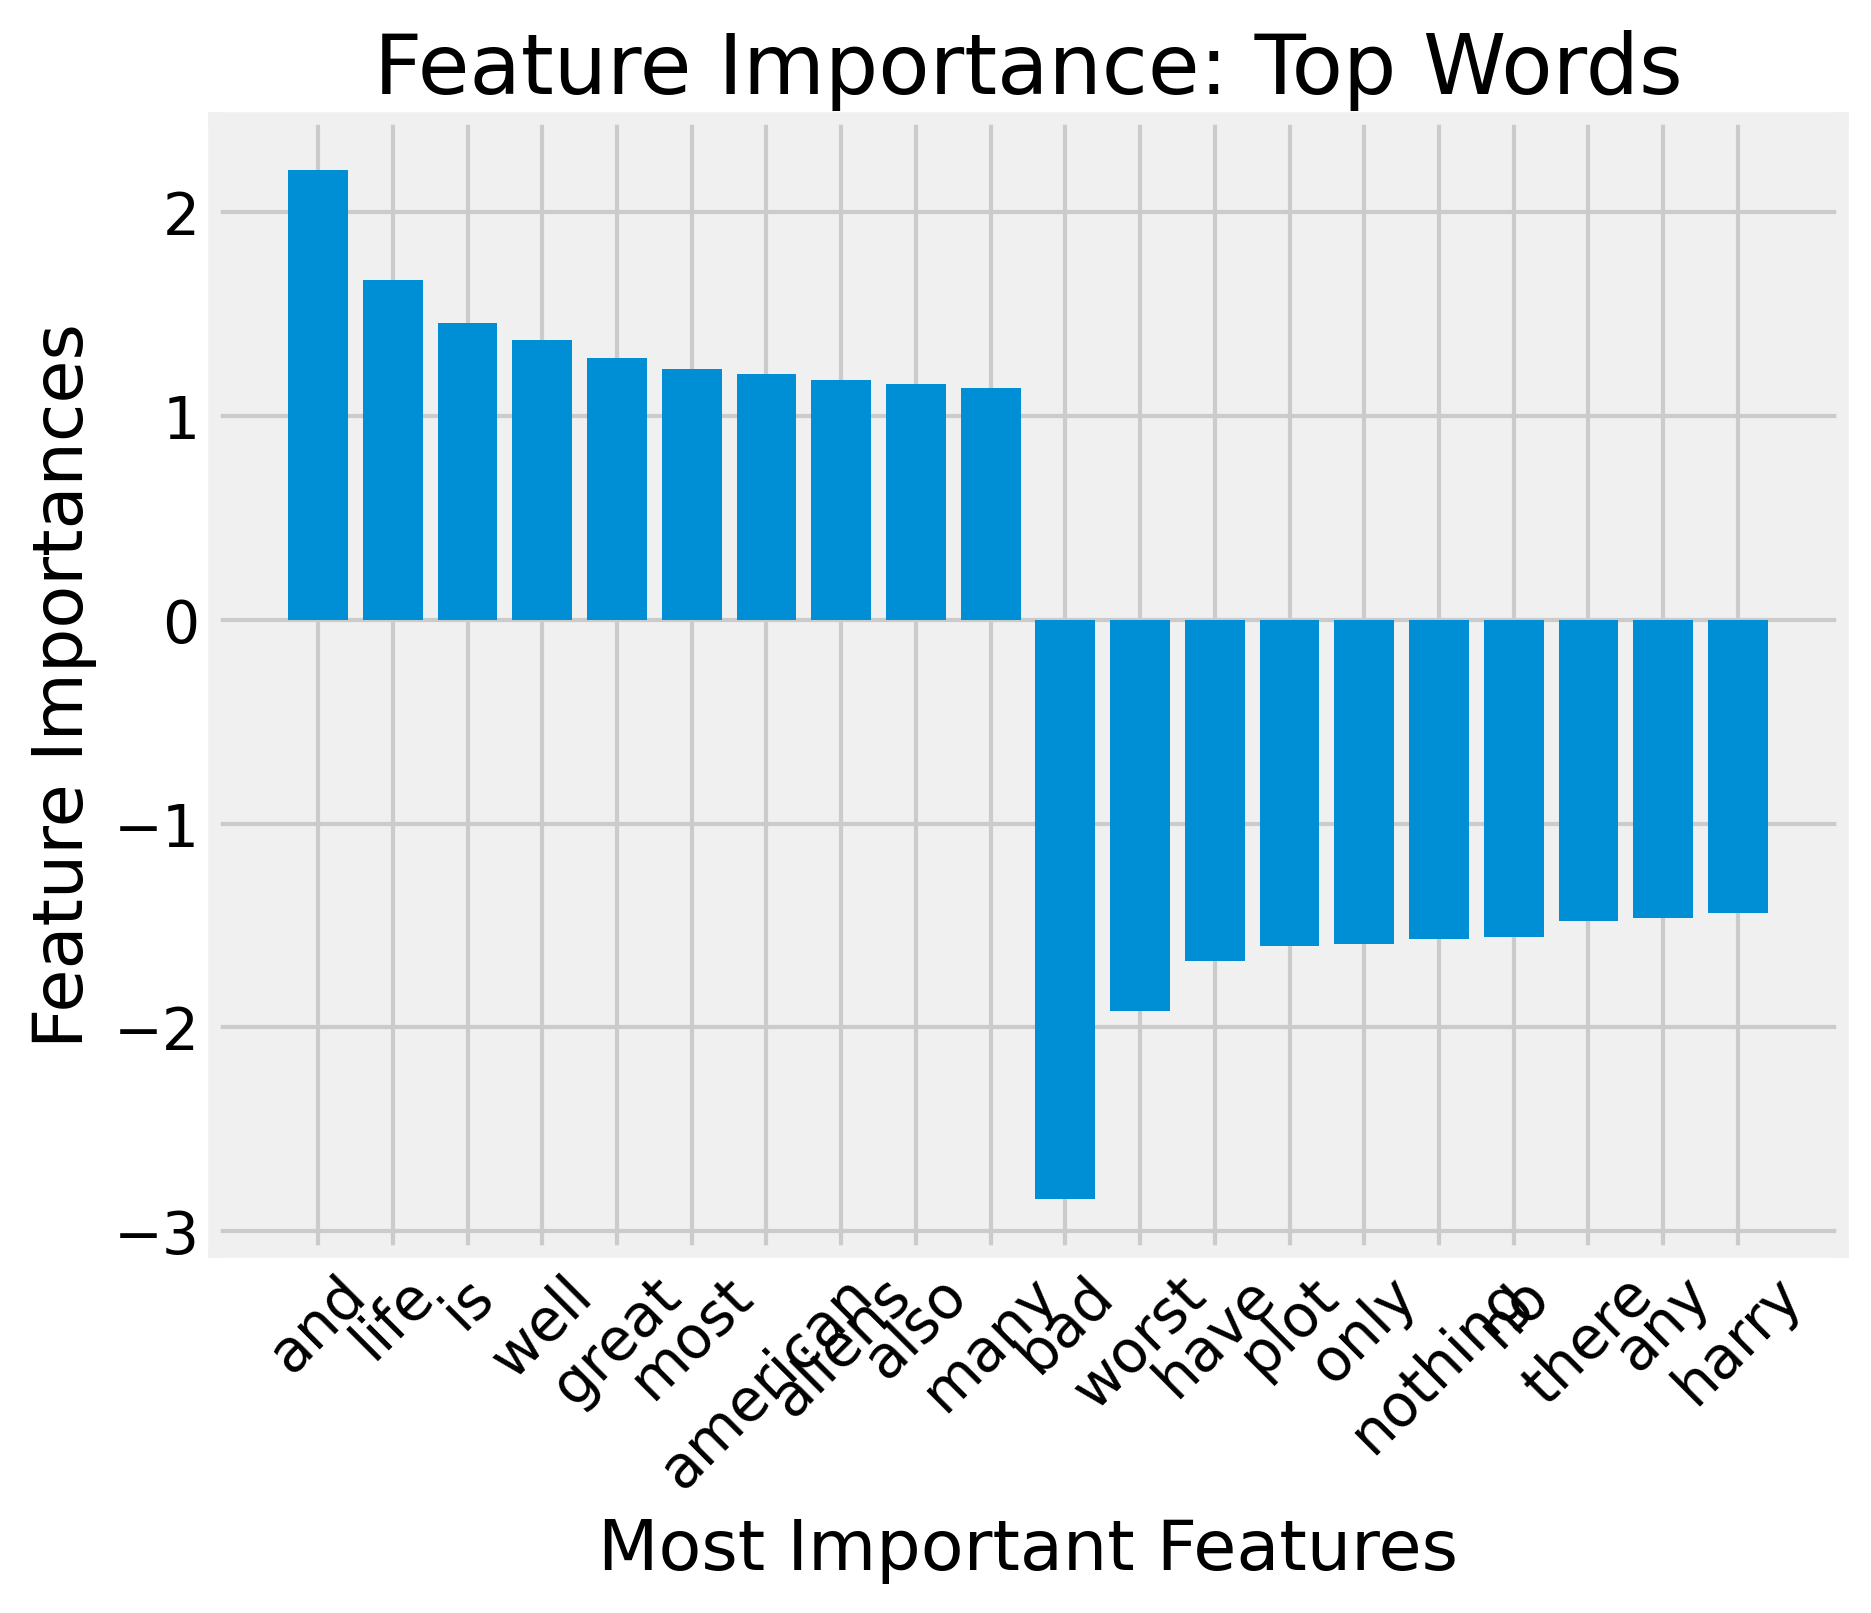

In [31]:
plt.figure(figsize=(7,5), dpi=300)
plt.style.use('fivethirtyeight')
#print(plt.style.available)
plt.bar(x = feature_importance_df['FEATURE'], height=feature_importance_df['IMPORTANCE'])
plt.xlabel("Most Important Features")
plt.ylabel("Feature Importances")
plt.xticks(rotation=45)
plt.title("Feature Importance: Top Words", color="black")

In [32]:
%load_ext rpy2.ipython

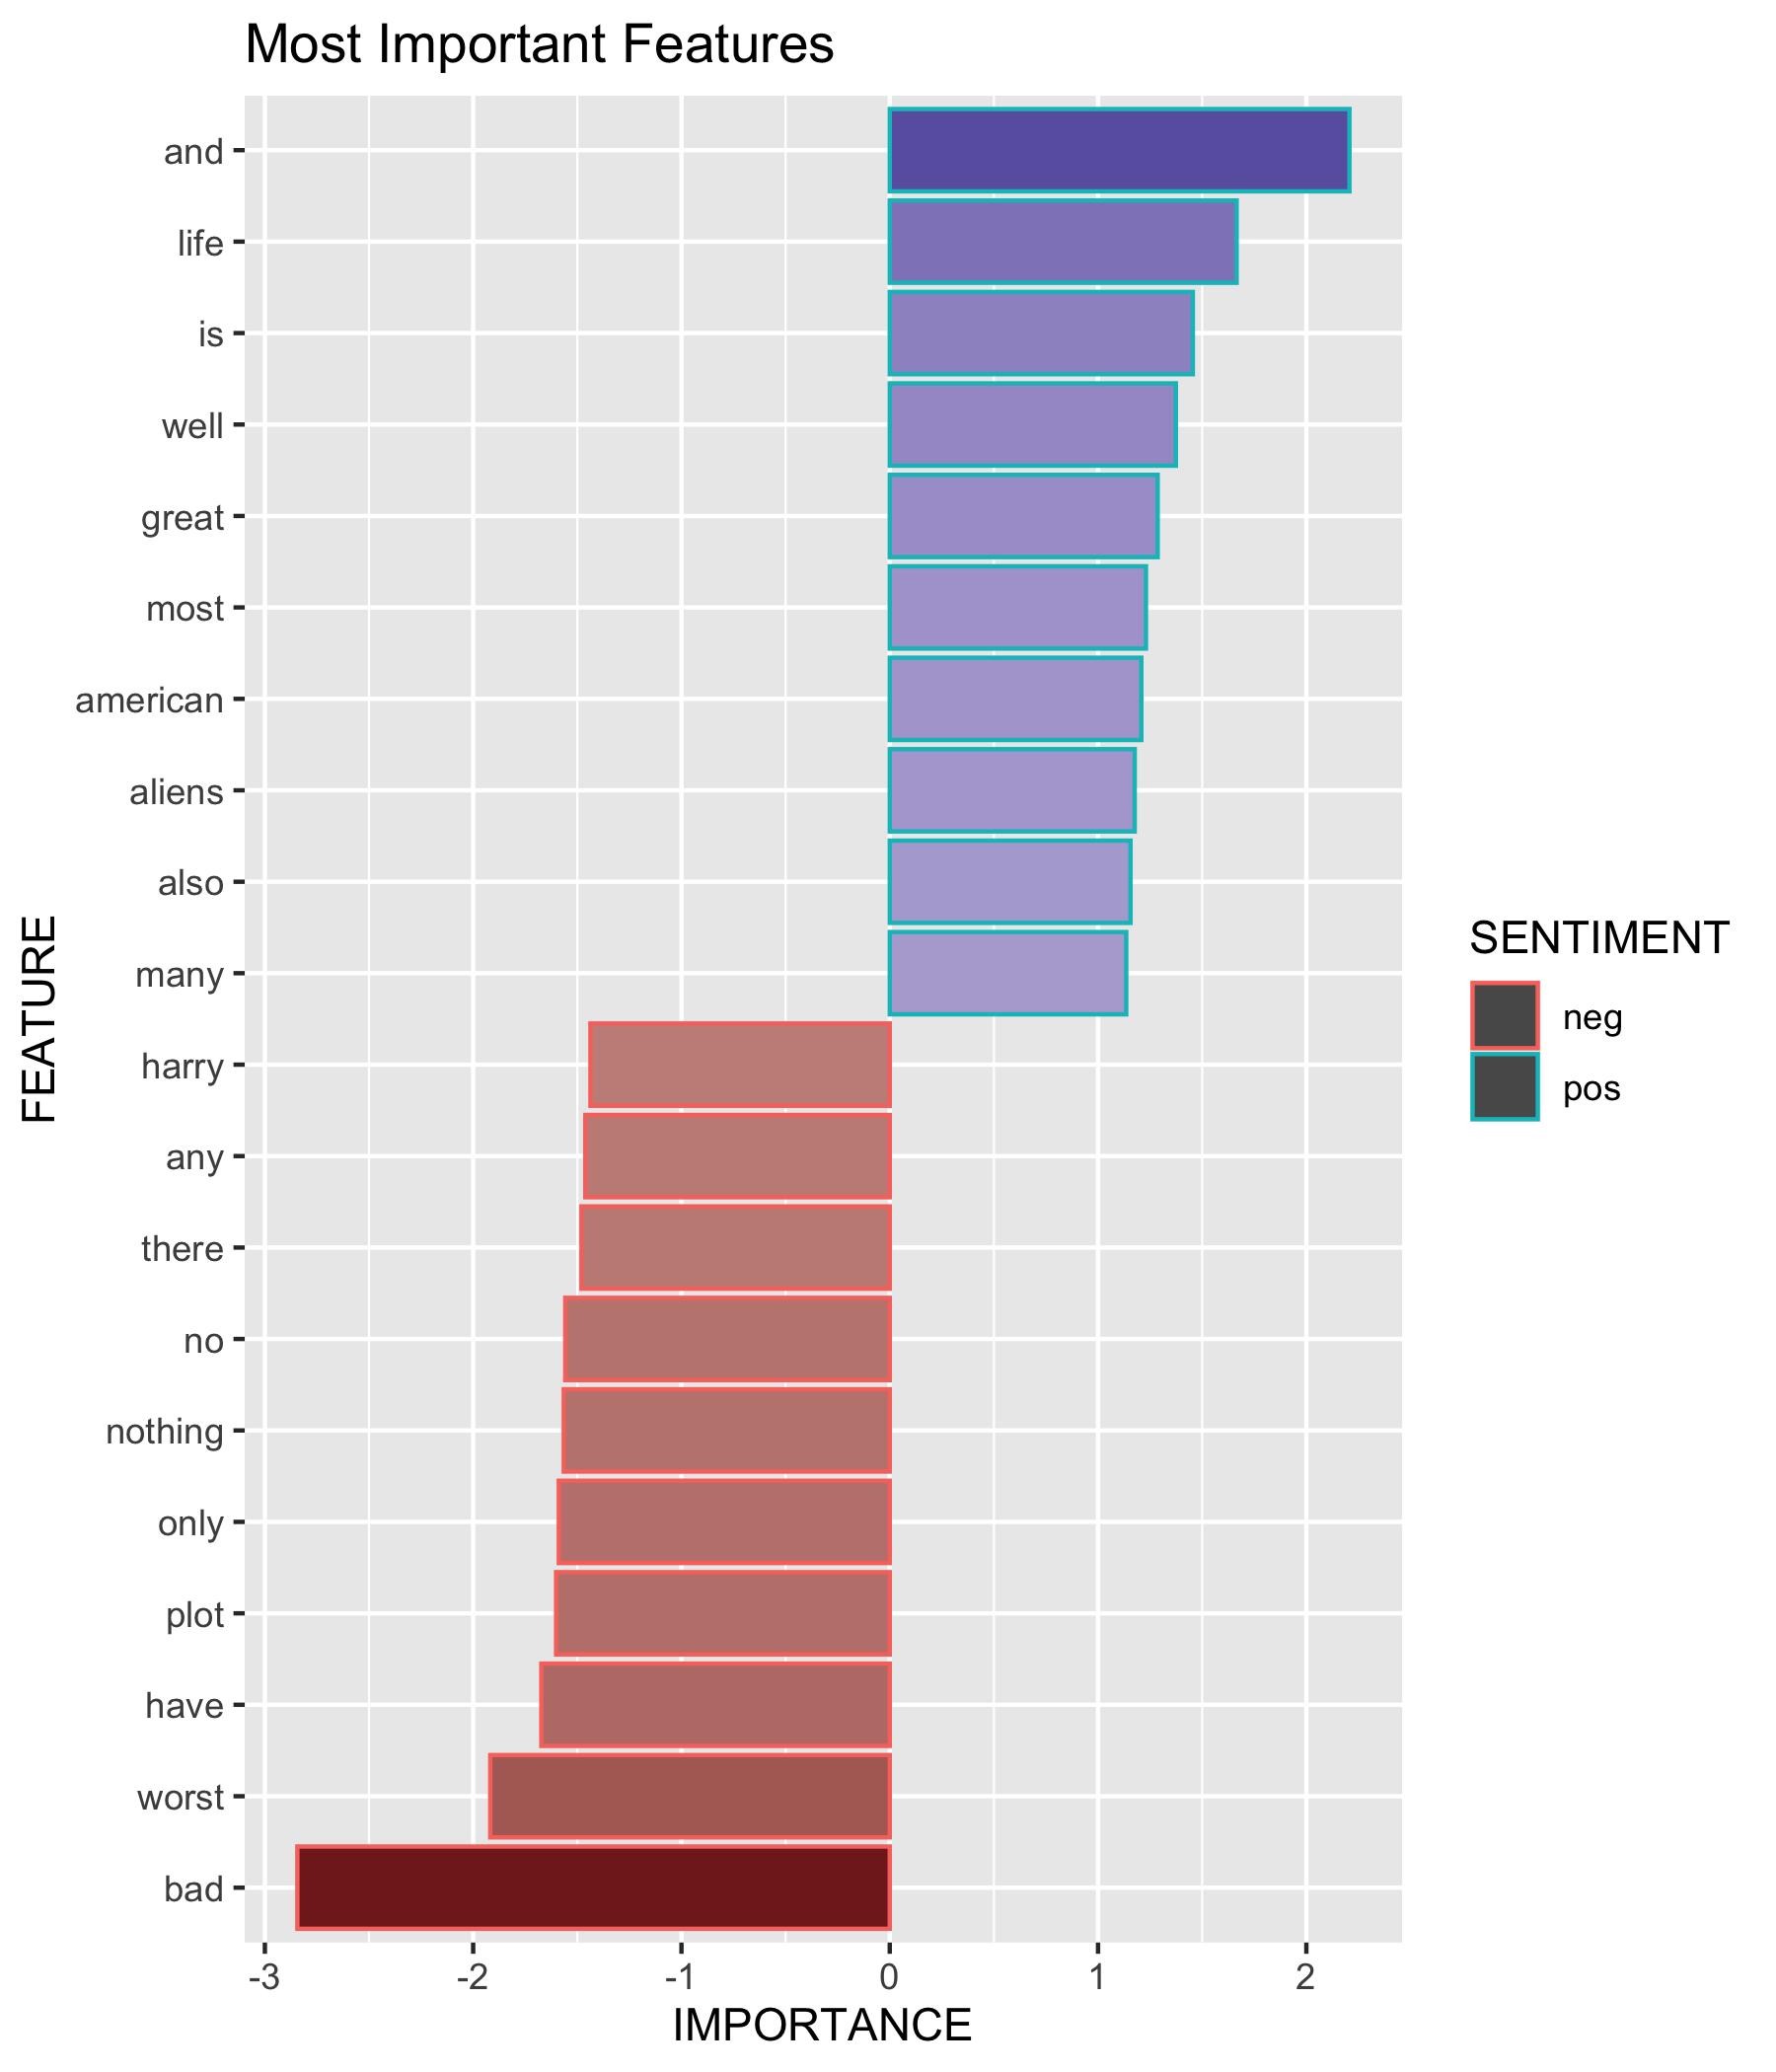

In [58]:
%%R -i feature_importance_df -w 6 -h 7 --units in -r 300
library(ggplot2)
library(dplyr)

head(feature_importance_df)

feature_importance_df %>%
    ggplot(aes(reorder(FEATURE,IMPORTANCE), IMPORTANCE, fill=IMPORTANCE, color=SENTIMENT)) +
     geom_bar(stat="identity") +
     coord_flip() +
     scale_fill_gradient2(guide=FALSE) +
     labs(x='FEATURE', x="IMPORTANCE", title="Most Important Features")

### Other Variants

- Some of the online code snippets try to implement the `show_most_informative_features()` in `nltk` classifier.
- Here the codes only work with linear classifiers (e.g., Logistic models) in sklearn.
- Need more updates. See this [SO post](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers)

In [34]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [35]:
show_most_informative_features(tfidf_vec, model_lg, n=20)

	-2.1472	bad            		2.1711	and            
	-1.4931	to             		1.6032	is             
	-1.2791	movie          		1.4057	life           
	-1.2686	have           		0.9768	the            
	-1.2678	worst          		0.9303	great          
	-1.1834	there          		0.9267	jackie         
	-1.1762	plot           		0.8682	as             
	-1.1259	no             		0.8533	his            
	-1.0679	boring         		0.8052	most           
	-1.0246	this           		0.7815	of             
	-0.9954	harry          		0.7603	american       
	-0.9943	any            		0.7535	scream         
	-0.9929	nothing        		0.7507	also           
	-0.9768	only           		0.7424	well           
	-0.9729	be             		0.7239	mulan          
	-0.9370	if             		0.7224	cameron        
	-0.9358	on             		0.7104	very           
	-0.8910	script         		0.7098	many           
	-0.8813	stupid         		0.7027	truman         
	-0.8675	supposed       		0.6996	family         


For tree-based classifiers, visualization is better.

In [36]:
import sklearn
from sklearn.tree import plot_tree
text_representation = sklearn.tree.export_text(model_dec, feature_names = tfidf_vec.get_feature_names())
print(text_representation)




|--- bad <= 0.01
|   |--- ridiculous <= 0.01
|   |   |--- nothing <= 0.02
|   |   |   |--- boring <= 0.02
|   |   |   |   |--- tv <= 0.03
|   |   |   |   |   |--- class: pos
|   |   |   |   |--- tv >  0.03
|   |   |   |   |   |--- class: neg
|   |   |   |--- boring >  0.02
|   |   |   |   |--- expect <= 0.01
|   |   |   |   |   |--- class: neg
|   |   |   |   |--- expect >  0.01
|   |   |   |   |   |--- class: pos
|   |   |--- nothing >  0.02
|   |   |   |--- and <= 0.16
|   |   |   |   |--- allows <= 0.02
|   |   |   |   |   |--- class: neg
|   |   |   |   |--- allows >  0.02
|   |   |   |   |   |--- class: pos
|   |   |   |--- and >  0.16
|   |   |   |   |--- do <= 0.02
|   |   |   |   |   |--- class: pos
|   |   |   |   |--- do >  0.02
|   |   |   |   |   |--- class: neg
|   |--- ridiculous >  0.01
|   |   |--- present <= 0.01
|   |   |   |--- own <= 0.02
|   |   |   |   |--- class: neg
|   |   |   |--- own >  0.02
|   |   |   |   |--- speak <= 0.02
|   |   |   |   |   |--- class: p

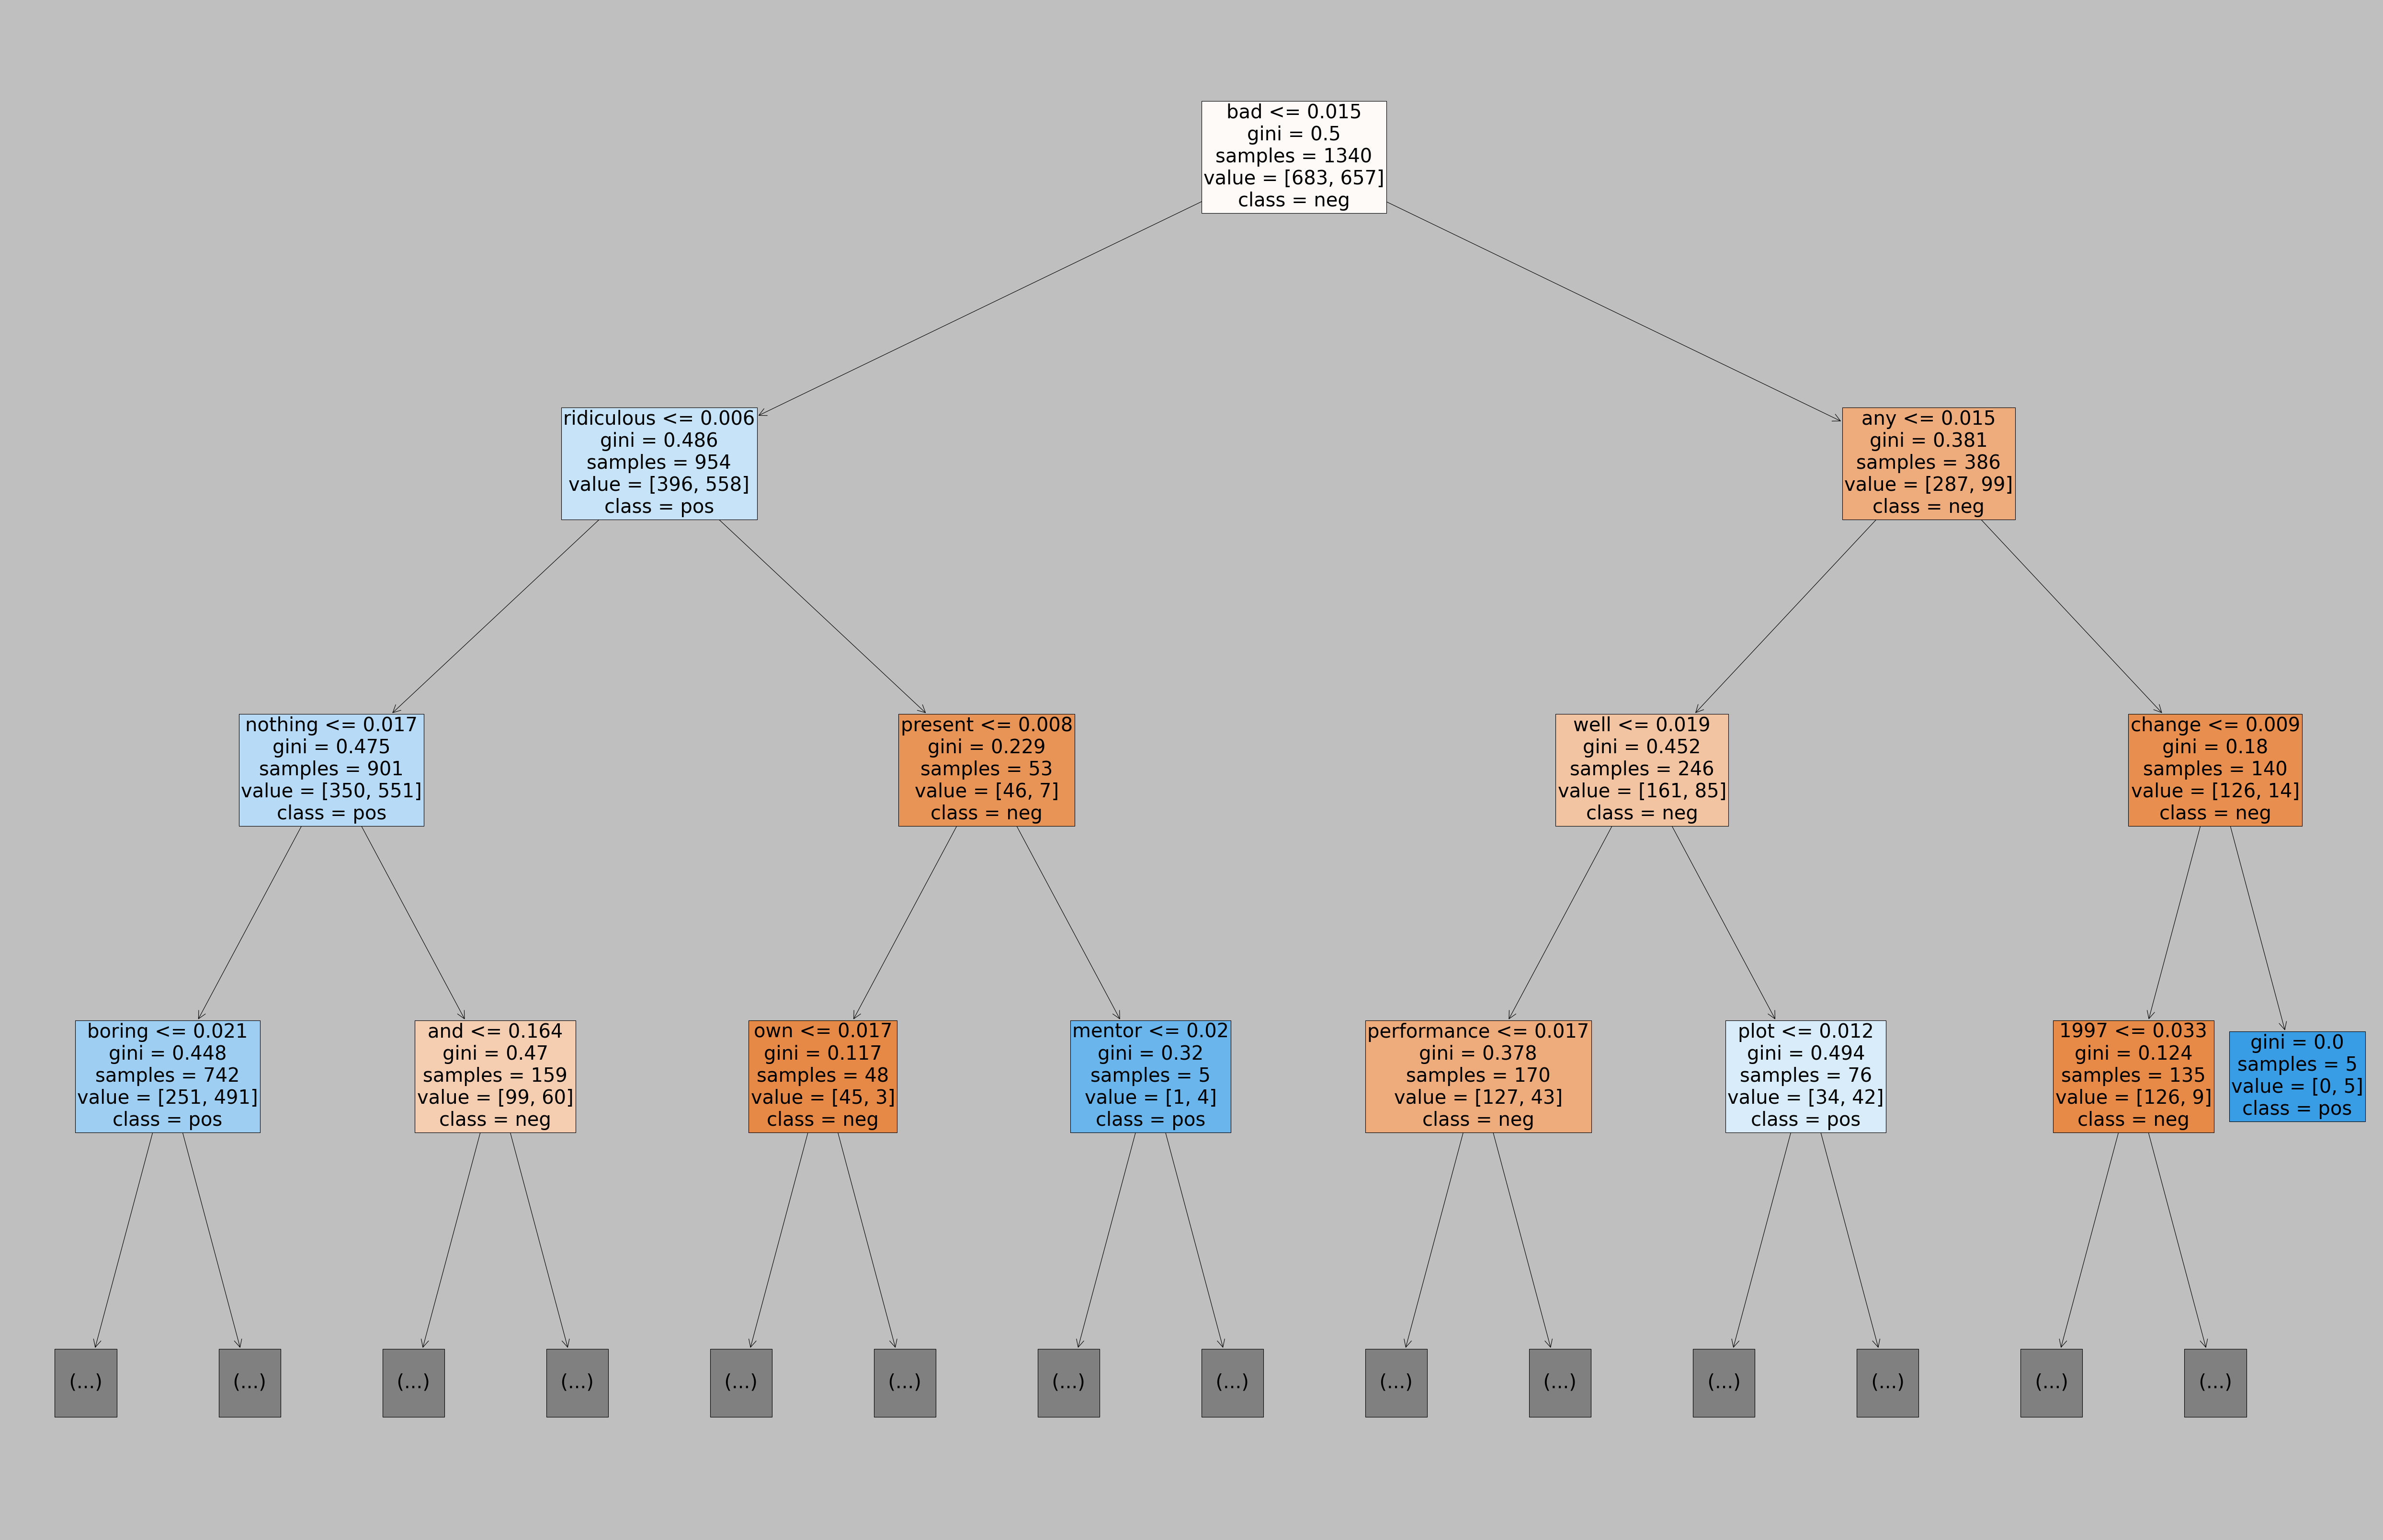

In [49]:
plt.style.use('classic')
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(80,50))
_ = sklearn.tree.plot_tree(model_dec, max_depth=3,
                   feature_names=tfidf_vec.get_feature_names(),  
                   class_names=model_dec.classes_,
                   filled=True, fontsize=36)

#fig.savefig("decistion_tree.png")

## Saving Model


In [38]:
#  import pickle

# with open('../ml-sent-svm.pkl', 'wb') as f:
#     pickle.dump(clf, f)
# with open('../ml-sent-svm.pkl' 'rb') as f:
#     loaded_svm = pickle.load(f)

## Package Requirement

In [39]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

In [40]:
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==0.23.2
pandas==1.1.2
numpy==1.19.2
nltk==3.5
matplotlib==3.3.2
lime==0.2.0.1


## References

- Geron (2019), Ch 2 and 3
- See [Keith Galli's sklearn tutorial](https://github.com/KeithGalli/sklearn)
- See a blog post, [LIME of words: Interpreting RNN Predictions](https://data4thought.com/deep-lime.html).
- See a blog post, [LIME of words: how to interpret your machine learning model predictions](https://data4thought.com/lime-of-words.html)